#### <b>[코드 구현] CycleGAN</b>

* <b>작성자</b>: 나동빈(dongbinna@postech.ac.kr)
* 논문 제목: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks <b>(ICCV 2017)</b>
* 본 소스코드는 원본 논문에서 제안한 아키텍처를 최대한 따르고 있습니다.
* <b>쌍이 맞지 않는 데이터셋(Unpaired Dataset)</b>으로부터 학습이 가능한 CycleGAN 모델을 학습해 봅시다.
* 학습 데이터셋: <b>Horse2Zebra</b> (3 X 256 X 256)
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.

#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [1]:
import os
import glob
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

#### <b>학습 데이터셋 불러오기</b>

* 학습을 위해 <b>Horse2Zebra</b> 데이터셋을 불러옵니다.

In [2]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./horse2zebra.zip

--2020-12-26 16:24:15--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./horse2zebra.zip’

./horse2zebra.zip   100%[===================>] 111.45M  4.07MB/s    in 36s     

2020-12-26 16:24:51 (3.11 MB/s) - ‘./horse2zebra.zip’ saved [116867962/116867962]



In [3]:
%%capture
!unzip ./horse2zebra.zip -d ./

In [4]:
# 학습을 위한 디렉토리(directory) 형식에 맞게 변형
!mkdir -p "horse2zebra/train"
!mkdir -p "horse2zebra/test"

!mv "horse2zebra/trainA" "horse2zebra/train/A"
!mv "horse2zebra/trainB" "horse2zebra/train/B"
!mv "horse2zebra/testA" "horse2zebra/test/A"
!mv "horse2zebra/testB" "horse2zebra/test/B"

In [5]:
print("학습 데이터셋 A의 개수:", len(next(os.walk('./horse2zebra/train/A'))[2]))
print("학습 데이터셋 B의 개수:", len(next(os.walk('./horse2zebra/train/B'))[2]))
print("테스트 데이터셋 A의 개수:", len(next(os.walk('./horse2zebra/test/A'))[2]))
print("테스트 데이터셋 B의 개수:", len(next(os.walk('./horse2zebra/test/B'))[2]))

학습 데이터셋 A의 개수: 1067
학습 데이터셋 B의 개수: 1334
테스트 데이터셋 A의 개수: 120
테스트 데이터셋 B의 개수: 140


* 학습 데이터셋을 출력해 봅시다.

이미지 크기: (256, 256)


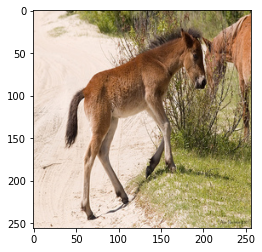

이미지 크기: (256, 256)


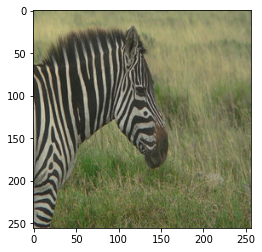

In [6]:
# 말(horse) 이미지 출력
image = Image.open('./horse2zebra/train/A/n02381460_1083.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

# 얼룩말(zebra) 이미지 출력
image = Image.open('./horse2zebra/train/B/n02391049_10007.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

* 커스텀 데이터셋(Custom Dataset) 클래스를 정의합니다.

In [7]:
# 흑백 이미지를 색상 이미지(R/G/B 채널)로 변환하기 위한 함수
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}/A") + "/*.jpg"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}/B") + "/*.jpg"))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)])
        img_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]) # img_B는 랜덤하게 샘플링

        # 만약 흑백(grayscale) 이미지라면 RGB 채널 이미지로 변환
        if img_A.mode != "RGB":
            img_A = to_rgb(img_A)
        if img_B.mode != "RGB":
            img_B = to_rgb(img_B)

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [10]:
transforms_ = transforms.Compose([
    transforms.Resize(int(256 * 1.12), Image.BICUBIC), # 이미지 크기를 조금 키우기
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(), # 각 데이터가 단일 이미지로 존재하므로 좌우 반전 가능
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("horse2zebra", transforms_=transforms_)
val_dataset = ImageDataset("horse2zebra", transforms_=transforms_)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

In [11]:
# 잔여 블록(Residual Block) 모듈 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        # 채널(channel) 크기는 그대로 유지
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.block(x)


# ResNet 기반의 생성자(Generator) 아키텍처
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0] # 입력 이미지의 채널 수: 3

        # 초기 콘볼루션 블록(Convolution Block) 레이어
        out_channels = 64
        model = [nn.ReflectionPad2d(channels)]
        model.append(nn.Conv2d(channels, out_channels, kernel_size=7))
        model.append(nn.InstanceNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        in_channels = out_channels

        # 다운샘플링(Downsampling)
        for _ in range(2):
            out_channels *= 2
            model.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)) # 너비와 높이가 2배씩 감소
            model.append(nn.InstanceNorm2d(out_channels))
            model.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        # 출력: [256 X (4배 감소한 높이) X (4배 감소한 너비)]

        # 인코더와 디코더의 중간에서 Residual Blocks 사용 (차원은 유지)
        for _ in range(num_residual_blocks):
            model.append(ResidualBlock(out_channels))

        # 업샘플링(Upsampling)
        for _ in range(2):
            out_channels //= 2
            model.append(nn.Upsample(scale_factor=2)) # 너비와 높이가 2배씩 증가
            model.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)) # 너비와 높이는 그대로
            model.append(nn.InstanceNorm2d(out_channels))
            model.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        # 출력: [256 X (4배 증가한 높이) X (4배 증가한 너비)]

        # 출력 콘볼루션 블록(Convolution Block) 레이어
        model.append(nn.ReflectionPad2d(channels))
        model.append(nn.Conv2d(out_channels, channels, kernel_size=7))
        model.append(nn.Tanh())

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # 콘볼루션 블록(Convolution Block) 모듈 정의
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)] # 너비와 높이가 2배씩 감소
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1) # 출력: [1 X 16 X 16]
        )
        # 최종 출력: [1 X (16배 감소한 높이) X (16배 감소한 너비)]

    def forward(self, img):
        return self.model(img)

#### <b>모델 학습 및 샘플링</b>

* 학습을 위한 별도의 유틸리티(utility) 클래스를 정의합니다.
* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
# 이미지 버퍼(Buffer) 클래스
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    # 새로운 이미지를 삽입하고, 이전에 삽입되었던 이미지를 반환하는 함수
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            # 아직 버퍼가 가득 차지 않았다면, 현재 삽입된 데이터를 반환
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            # 버퍼가 가득 찼다면, 이전에 삽입되었던 이미지를 랜덤하게 반환
            else:
                if random.uniform(0, 1) > 0.5: # 확률은 50%
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element # 버퍼에 들어 있는 이미지 교체
                else:
                    to_return.append(element)
        return torch.cat(to_return)


# 시간이 지남에 따라 학습률(learning rate)을 감소시키는 클래스
class LambdaLR:
    def __init__(self, n_epochs, decay_start_epoch):
        self.n_epochs = n_epochs # 전체 epoch
        self.decay_start_epoch = decay_start_epoch # 학습률 감소가 시작되는 epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


# 가중치 초기화를 위한 함수 정의
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
G_AB = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
G_BA = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
D_A = Discriminator(input_shape=(3, 256, 256))
D_B = Discriminator(input_shape=(3, 256, 256))

G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

# 가중치(weights) 초기화
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_cycle.cuda()
criterion_identity.cuda()

n_epochs = 200 # 학습의 횟수(epoch) 설정
decay_epoch = 100 # 학습률 감소가 시작되는 epoch 설정
lr = 0.0002 # 학습률(learning rate) 설정

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A  = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# 학습률(learning rate) 업데이트 스케줄러 초기화
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, decay_epoch).step)

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.
    * Epoch 20번 이상부터 그럴싸한 이미지를 생성하게 됩니다.
    * Google Colab 기준으로 수십 시간 소요될 수 있습니다.

In [ ]:
import time

sample_interval = 50 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

lambda_cycle = 10 # Cycle 손실 가중치(weight) 파라미터
lambda_identity = 5 # Identity 손실 가중치(weight) 파라미터

# 이전에 생성된 이미지 데이터를 포함하고 있는 버퍼(buffer) 객체
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습합니다. """
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity 손실(loss) 값 계산
        loss_identity_A = criterion_identity(G_BA(real_A), real_A)
        loss_identity_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_identity_A + loss_identity_B) / 2

        # GAN 손실(loss) 값 계산
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), real)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), real)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle 손실(loss) 값 계산
        recover_A = G_BA(fake_B)
        recover_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recover_A, real_A)
        loss_cycle_B = criterion_cycle(recover_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_identity * loss_identity

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator) A를 학습합니다. """
        optimizer_D_A.zero_grad()

        # Real 손실(loss): 원본 이미지를 원본으로 판별하도록
        loss_real = criterion_GAN(D_A(real_A), real)

        # Fake 손실(loss): 가짜 이미지를 가짜로 판별하도록
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)

        # 최종적인 손실(loss)
        loss_D_A = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D_A.backward()
        optimizer_D_A.step()

        """ 판별자(discriminator) B를 학습합니다. """
        optimizer_D_B.zero_grad()

        # Real 손실(loss): 원본 이미지를 원본으로 판별하도록
        loss_real = criterion_GAN(D_B(real_B), real)

        # Fake 손실(loss): 가짜 이미지를 가짜로 판별하도록
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)

        # 최종적인 손실(loss)
        loss_D_B = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            G_AB.eval()
            G_BA.eval()
            imgs = next(iter(val_dataloader)) # 5개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            # X축을 따라 각각의 그리디 이미지 생성
            real_A = make_grid(real_A, nrow=4, normalize=True)
            real_B = make_grid(real_B, nrow=4, normalize=True)
            fake_A = make_grid(fake_A, nrow=4, normalize=True)
            fake_B = make_grid(fake_B, nrow=4, normalize=True)
            # 각각의 격자 이미지를 높이(height)를 기준으로 연결하기 
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
            save_image(image_grid, f"{done}.png", normalize=False)
            print(f"[Done {i}/{len(train_dataloader)}] [Elapsed time: {time.time() - start_time:.2f}s]")

    # 학습률(learning rate)
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G identity loss: {loss_identity.item():.6f}, adv loss: {loss_GAN.item()}, cycle loss: {loss_cycle.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

    # 하나의 epoch이 끝날 때마다 모델 파라미터 저장
    torch.save(G_AB.state_dict(), "G_AB.pt")
    torch.save(G_BA.state_dict(), "G_BA.pt")
    torch.save(D_A.state_dict(), "D_A.pt")
    torch.save(D_B.state_dict(), "D_B.pt")
    print("Model saved!")

#### <b>학습된 모델 파라미터 저장 및 테스트</b>

* 다음의 코드를 이용하여 학습된 모델 파라미터를 다운로드 받을 수 있습니다.
* 학습을 모두 완료하지는 않았으며 학습 횟수(epoch) 30번까지 반복한 상태에서의 파라미터를 저장하였습니다.

In [ ]:
# 모델 파라미터 저장
torch.save(G_AB.state_dict(), "CycleGAN_G_AB_for_Horse2Zebra.pt")
torch.save(G_BA.state_dict(), "CycleGAN_G_BA_for_Horse2Zebra.pt")
torch.save(D_A.state_dict(), "CycleGAN_D_A_for_Horse2Zebra.pt")
torch.save(D_B.state_dict(), "CycleGAN_D_B_for_Horse2Zebra.pt")
print("Model saved!")

Model saved!


In [ ]:
# 모델 파라미터 다운로드
from google.colab import files

files.download('CycleGAN_G_AB_for_Horse2Zebra.pt')
files.download('CycleGAN_G_BA_for_Horse2Zebra.pt')
files.download('CycleGAN_D_A_for_Horse2Zebra.pt')
files.download('CycleGAN_D_B_for_Horse2Zebra.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* 학습된 모델을 불러와 테스트를 진행할 수 있습니다.

In [8]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXMlQ_FrekdGo-A-DMPcwfsBatwaAfVJ1p2HCegX-0gacw?download=1 -O CycleGAN_G_AB_for_Horse2Zebra.pt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfU1PMf8r39Ku_YJtkhidacBSu963Gr7d-8VKgSuSHWMCA?download=1 -O CycleGAN_G_BA_for_Horse2Zebra.pt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ee2nFja4w3NHluFU1n43Z6oBpIM4sFX0GsgpoZdBpxGS7A?download=1 -O CycleGAN_D_A_for_Horse2Zebra.pt
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUgH2KGMRUZNsPYKrTGkC2wBUVN1ksNuvYKheYE37PAQIA?download=1 -O CycleGAN_D_B_for_Horse2Zebra.pt

--2020-12-26 16:26:56--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXMlQ_FrekdGo-A-DMPcwfsBatwaAfVJ1p2HCegX-0gacw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CycleGAN/CycleGAN_G_AB_for_Horse2Zebra.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWE1sUV9GcmVrZEdvLUEtRE1QY3dmc0JhdHdhQWZWSjFwMkhDZWdYLTBnYWN3P3J0aW1lPUpMOXZFYnVwMkVn [following]
--2020-12-26 16:26:59--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CycleGAN/CycleGAN_G_AB_for_Horse2Zebra.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGV

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
G_AB = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
G_BA = GeneratorResNet(input_shape=(3, 256, 256), num_residual_blocks=9)
D_A = Discriminator(input_shape=(3, 256, 256))
D_B = Discriminator(input_shape=(3, 256, 256))

G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

G_AB.load_state_dict(torch.load("CycleGAN_G_AB_for_Horse2Zebra.pt"))
G_BA.load_state_dict(torch.load("CycleGAN_G_BA_for_Horse2Zebra.pt"))
D_A.load_state_dict(torch.load("CycleGAN_D_A_for_Horse2Zebra.pt"))
D_B.load_state_dict(torch.load("CycleGAN_D_B_for_Horse2Zebra.pt"))

G_AB.eval();
G_BA.eval();
D_A.eval();
D_B.eval();

In [ ]:
from PIL import Image

imgs = next(iter(val_dataloader)) # 5개의 이미지를 추출해 생성
real_A = imgs["B"].cuda()
real_B = imgs["A"].cuda()
fake_B = G_AB(real_A)
fake_A = G_BA(real_B)
# X축을 따라 각각의 그리디 이미지 생성
real_A = make_grid(real_A, nrow=4, normalize=True)
real_B = make_grid(real_B, nrow=4, normalize=True)
fake_A = make_grid(fake_A, nrow=4, normalize=True)
fake_B = make_grid(fake_B, nrow=4, normalize=True)
# 각각의 격자 이미지를 높이(height)를 기준으로 연결하기 
image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
save_image(image_grid, f"result.png", normalize=False)

In [ ]:
from IPython.display import Image

Image('result.png')